In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
import segmentation_models_pytorch as smp
from utils_unet import * 
from utils_data import *
from utils_models import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pickle
import torch.optim as optim
from torch.utils.data import DataLoader, random_split,Dataset

from torchsummary import summary
import matplotlib.cm as cm

In [76]:
plt.rcParams.update({'font.size': 17})

### Getting data

Here we get data 1985-2011 for train and validation. Train set has 249 time steps.

In [6]:
# define target to be from 'precip_ncep' 'tmp_ncep' 'precip_nasa' 'tmp_nasa'
TARGET = 'tmp_ncep'

PATH = '/share/data/willett-group/climate/'

mask_US = np.load('train_val/mask_US.npy')

In [7]:
ens_forecasts_all, target_rect, target_for_lags = get_train_val_ens_target(TARGET, PATH)

tmp_precip, rhum, ght, pressure, sst_train, sst_val = get_train_val_obs_data(TARGET, PATH)

In [8]:
print(ens_forecasts_all.shape, target_rect.shape, mask_US.shape)

(312, 24, 64, 128) (312, 64, 128) (64, 128)


In [10]:
print(tmp_precip.shape, ght.shape, pressure.shape)

((324, 64, 128), (324, 64, 128), (324, 64, 128))

In [11]:
print(sst_train.shape, sst_val.shape)

((249, 100), (63, 100))

In [12]:
# let's define positional encoding

grid_lat, grid_lon = np.mgrid[52.75:21.25:64j, 233.25:296.75:128j]

coordinates = np.zeros((2, grid_lat.shape[0], grid_lat.shape[1]))
coordinates[0] = grid_lat
coordinates[1] = grid_lon

PE_dim = 12
pe0 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[0].reshape(64*128))
pe1 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[1].reshape(64*128))

pe_channels = np.zeros((PE_dim*2, 64, 128))
pe_channels[:PE_dim, :, :] = pe0.T.reshape(PE_dim, 64, 128)
pe_channels[-PE_dim:, :, :] = pe1.T.reshape(PE_dim, 64, 128)

In [13]:
train_val_size = 312

In [14]:
sst_ftr = np.concatenate((sst_train[:, :8], sst_val[:, :8]), axis=0)
sst_img = np.zeros((train_val_size, 8, 64, 128))

for i in range(train_val_size):
    for j in range(8): # number of components
        sst_img[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])

In [16]:
# create features 
# it's easy to vary what features to include
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    dim_shape = 24 + 24 + 5 + 4 #+ 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :24, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 24, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 25, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 26, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 27, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 28, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 29, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 30, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 31, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 32, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 33:33+2*PE_dim, :, :] = pe_channels
#     X_ftrs_hind[:, -8:, :, :] = sst_img
    
elif TARGET == 'tmp_nasa' or TARGET == 'precip_nasa':
    print(TARGET)
    dim_shape = 11 + 4 + 24 + 5 #+ 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :11, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 11, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 12, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 13, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 14, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 15, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 16, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 20:20+2*PE_dim, :, :] = pe_channels
#     X_ftrs_hind[:, -8:, :, :] = sst_img

Let's download our observational climatology: it has shape of our train and test data: there are 312 steps starting from January.

In [19]:
trend = get_obs_trend(TARGET, PATH)
trend[:, mask_US == 0] = 0

tmp


In [20]:
trend_cropped_US = np.zeros((trend.shape[0], 48, 115))

for i in range(trend.shape[0]):
    trend_cropped_US[i] = crop_to_US_land(trend[i])

In [23]:
train_size = 250
X_train = X_ftrs_hind[:train_size]
X_val = X_ftrs_hind[train_size:]
y_train = target_rect[:train_size]
y_val = target_rect[train_size:]

In [26]:
X_mins = np.min(X_train, axis=(0, 2, 3)).reshape(1, X_ftrs_hind.shape[1], 1, 1) #np.amin(X_train)
X_maxs = np.max(X_train, axis=(0, 2, 3)).reshape(1, X_ftrs_hind.shape[1], 1, 1) #np.amax(X_train)
X_train = X_train - X_mins
X_val = X_val - X_mins
X_train = X_train/(X_maxs - X_mins)
X_val = X_val/(X_maxs - X_mins)


if 'precip' in TARGET:
    y_min = np.min(y_train)
    y_max = np.max(y_train)
    y_train = y_train - y_min
    y_val = y_val - y_min
    y_train = y_train/(y_max - y_min)
    y_val = y_val/(y_max - y_min)
elif 'tmp' in TARGET:
    y_mean = np.mean(y_train[:, mask_US==1])
    y_std = np.std(y_train[:, mask_US==1])
    y_train = (y_train - y_mean) / y_std
    y_val = (y_val - y_mean) / y_std
    y_train = y_train * mask_US
    y_val = y_val * mask_US

print(np.min(X_train), np.max(X_train), np.min(X_val), np.max(X_val))
print(np.min(y_train), np.max(y_train), np.min(y_val), np.max(y_val))

BATCH_SIZE = 16
dataset_train = SimpleDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )


dataset_val = SimpleDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val,
                              batch_size=64,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

0.0 1.0 0.0 1.0151855936812366
-3.4918894795825 2.547370826216889 -3.104785550790376 2.5306543066692764


In [27]:
! echo $CUDA_VISIBLE_DEVICES

0


In [28]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
mask_US_tensor = torch.from_numpy(mask_US).float()

In [80]:
# Run Test for grid search
def run_test(X_train, y_train, X_val, y_val, mask, lr=0.001, BATCH_SIZE=16, dropout=0.2, num_epochs = 50):
    dataset_train = SimpleDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=0,
                                  pin_memory=False
                                 )

    dataset_val = SimpleDataset(X_val, y_val)
    dataloader_val = DataLoader(dataset_val,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=0,
                                  pin_memory=False
                                 )
    
    model = smp.Unet(encoder_name="vgg11",        
                     encoder_weights=None,     
                     in_channels=X_train.shape[1],                  
                     classes=1,
                     activation='sigmoid').to(device)
    
    distance = smp.utils.losses.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

    losses = []
    losses_val = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for idx_batch, (x, y) in enumerate(dataloader_train):
            x, y = x.to(device).float(), y.to(device).float()
            
            output = model(x)
            loss = distance(output.squeeze() * mask.to(device), y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        scheduler.step()
        train_loss = running_loss/len(dataloader_train)
        losses.append(train_loss)

        # validation 
        model.eval()
        with torch.no_grad():
            running_loss = 0
            for x, y in dataloader_val:
                x, y = x.to(device).float(), y.to(device).float()

                output = model(x)

                loss = distance(output * mask.to(device), y)
                running_loss += loss.item()

        val_loss = running_loss/len(dataloader_val)
        losses_val.append(val_loss)
    return losses, losses_val, model

In [81]:
val_size = 25
min_val_loss = {"loss": 10000}
file_name = 'unet_val.txt'

def run_CV(X_train, y_train, mask, lr, BATCH_SIZE, NUM_EPOCHS):           
    final_loss_train = np.zeros(10)
    final_loss_val = np.zeros(10)
    for i in range(10):
        X_val_temp = X_train[i*val_size:(i+1)*val_size,:,:,:]
        y_val_temp = y_train[i*val_size:(i+1)*val_size,:,:]
        X_train_temp = np.concatenate((X_train[0:i*val_size,:,:,:],X_train[(i+1)*val_size:,:,:,:]),axis=0)
        y_train_temp = np.concatenate((y_train[0:i*val_size,:,:],y_train[(i+1)*val_size:,:,:]),axis=0)
        losses, losses_val, model = run_test(X_train_temp,y_train_temp,X_val_temp,y_val_temp, mask, lr=lr, 
                                      BATCH_SIZE=BATCH_SIZE, num_epochs=NUM_EPOCHS)
        final_loss_train[i] = losses[-1]
        final_loss_val[i] = losses_val[-1]
        
    print("lr =", lr, ", batch size =", BATCH_SIZE )
    print("lr =", lr, ", batch size =", BATCH_SIZE, file=open(file_name, "a"))
    print("average training loss:", final_loss_train.mean())
    print("average training loss:", final_loss_train.mean(), file=open(file_name, "a"))
    print("average validation loss:", final_loss_val.mean())
    print("average validation loss:", final_loss_val.mean(), file=open(file_name, "a"))
    
    if final_loss_val.mean() < min_val_loss["loss"]:
        min_val_loss["loss"] = final_loss_val.mean()
        print('min val and best params:', min_val_loss["loss"], "lr =", lr, ", batch size =", BATCH_SIZE)
        print('min val and best params:', min_val_loss["loss"], "lr =", lr, ", batch size =", BATCH_SIZE, file=open(file_name, "a"))
#         torch.save(model.to('cpu'), 'models/UNET_new.pth')

In [1]:
# Set Hyperparameters here!!!
# you can also vary number of epochs, weight decay etc
lr_grid = [0.001, 0.0001] 
BATCH_SIZE_grid = [8, 16, 32, 64]

for lr in lr_grid:
    for BATCH_SIZE in BATCH_SIZE_grid:
        run_CV(X_train, y_train, lr, mask_US_tensor, BATCH_SIZE, NUM_EPOCHS=170)

In [31]:
train_size = 249 
X_train = X_ftrs_hind[:train_size]
X_val = X_ftrs_hind[train_size:]

y_train = target_rect[:train_size]
y_val = target_rect[train_size:]


X_mins = np.min(X_train, axis=(0, 2, 3)).reshape(1, X_ftrs_hind.shape[1], 1, 1)
X_maxs = np.max(X_train, axis=(0, 2, 3)).reshape(1, X_ftrs_hind.shape[1], 1, 1)
X_train = X_train - X_mins
X_val = X_val - X_mins
X_train = X_train/(X_maxs - X_mins)
X_val = X_val/(X_maxs - X_mins)


if 'precip' in TARGET:
    y_min = np.min(y_train)
    y_max = np.max(y_train)
    y_train = y_train - y_min
    y_val = y_val - y_min
    y_train = y_train/(y_max - y_min)
    y_val = y_val/(y_max - y_min)
elif 'tmp' in TARGET:
    y_mean = np.mean(y_train[:, mask_US==1])
    y_std = np.std(y_train[:, mask_US==1])
    y_train = (y_train - y_mean) / y_std
    y_val = (y_val - y_mean) / y_std
    y_train = y_train * mask_US
    y_val = y_val * mask_US

print(np.min(X_train), np.max(X_train), np.min(X_val), np.max(X_val))
print(np.min(y_train), np.max(y_train), np.min(y_val), np.max(y_val))

BATCH_SIZE = 16
dataset_train = SimpleDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )


dataset_val = SimpleDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val,
                              batch_size=64,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )


0.0 1.0 0.0 1.0151855936812366
-3.4859739403137504 2.5439432256385666 -3.0994688872048926 2.527252567665382


In [32]:
model = smp.Unet(
    encoder_name="vgg11",        
    encoder_weights=None,     
    in_channels=X_ftrs_hind.shape[1],           
    classes=1,                      
    activation='sigmoid' # None
).to(device)

distance = smp.utils.losses.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [41]:
num_epochs = 170
losses = []
losses_test = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    with tqdm(total=len(dataloader_train), desc=f"[Epoch {epoch+1:3d}/{num_epochs}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            x, y = x.to(device).float(), y.to(device).float()

            output = model(x)
            loss = distance(output.squeeze() * mask_US_tensor.to(device), y)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.update(x.shape[0])
        
        scheduler.step()
        train_loss = running_loss/len(dataloader_train)
        losses.append(train_loss)
        
        pbar.set_postfix({'train loss': train_loss})
        pbar.update(x.shape[0])

        # validation 
        model.eval()
        with torch.no_grad():
            running_loss = 0
            for x, y in dataloader_val:
                x, y = x.to(device).float(), y.to(device).float()

                output = model(x)

                loss = distance(output.squeeze() * mask_US_tensor.to(device), y)
                running_loss += loss.item()

        test_loss = running_loss/len(dataloader_val)
        losses_test.append(test_loss)

[Epoch   1/170]: 258it [00:01, 148.34it/s, train loss=0.0214]
[Epoch   2/170]: 258it [00:02, 124.15it/s, train loss=0.00347]   
[Epoch   3/170]: 258it [00:01, 150.61it/s, train loss=0.00212]
[Epoch   4/170]: 258it [00:01, 144.10it/s, train loss=0.0017]
[Epoch   5/170]: 258it [00:01, 159.75it/s, train loss=0.0015]
[Epoch   6/170]: 258it [00:01, 156.64it/s, train loss=0.00138]
[Epoch   7/170]: 258it [00:01, 136.65it/s, train loss=0.00132]   
[Epoch   8/170]: 258it [00:02, 120.20it/s, train loss=0.00127]
[Epoch   9/170]: 258it [00:02, 128.33it/s, train loss=0.00123]
[Epoch  10/170]: 258it [00:01, 165.88it/s, train loss=0.00121]
[Epoch  11/170]: 258it [00:01, 166.43it/s, train loss=0.0012]
[Epoch  12/170]: 258it [00:01, 161.17it/s, train loss=0.0012]
[Epoch  13/170]: 258it [00:01, 165.93it/s, train loss=0.0012]
[Epoch  14/170]: 258it [00:01, 162.15it/s, train loss=0.0012]
[Epoch  15/170]: 258it [00:01, 166.02it/s, train loss=0.00119]
[Epoch  16/170]: 258it [00:01, 166.63it/s, train loss=0.

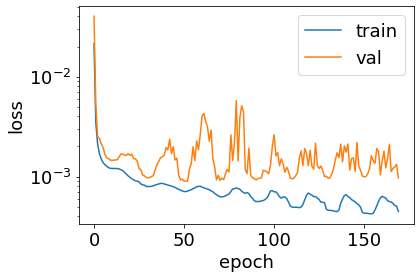

In [42]:
plt.plot(losses, label='train')
plt.plot(losses_test, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()

In [43]:
# saving the model

# torch.save(model.to('cpu'), 'models/Unet.pth')
# model.to(device);

In [36]:
# loading the model 

# model = torch.load(PATH + 'data/models/models/model_UNET_tmp_ncep_woSST_new.pth')
# model_UNET_tmp_ncep_woSST_new model_UNET_land_sst_ep170_new_best_m0
# model = torch.load('models/UNET_precip_nasa_all_n006.pth')
# model = torch.load('models/model_UNET_tmp_nasa_nosst_150_m010.pth')
# model.to(device);

In [37]:
model.eval();
pred_all = pred(model, dataloader_train, dataloader_val, mask_US_tensor, device=device)
# pred_all = pred_all.squeeze() * (y_max - y_min) + y_min
pred_all = pred_all.squeeze() * y_std + y_mean

In [38]:
pred_all_cropped_US = np.zeros((312, 48, 115)) 
for i in range(pred_all.shape[0]):
    pred_all_cropped_US[i] = crop_to_US_land(pred_all[i] * mask_US)
    
    
target_rect_cropped_US = np.zeros((312, 48, 115))
for i in range(pred_all.shape[0]):
    target_rect_cropped_US[i] = crop_to_US_land(target_rect[i])
    
mask_US_cropped = crop_to_US_land(mask_US)

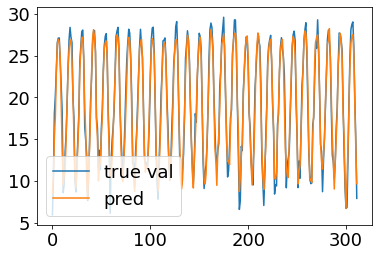

In [55]:
plt.plot(target_rect_cropped_US[:, 35, 70], label='true val')
plt.plot(pred_all_cropped_US[:, 35, 70], label='pred')
plt.legend()

In [100]:
print(TARGET, 'UNET val: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_rect_cropped_US[train_size:, mask_US_cropped==1]))

tmp_nasa UNET val: mean, std, SE, percentile: [3.01 1.24 0.02 2.79 3.81 4.52]


In [79]:
print(TARGET, 'UNET val: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_rect_cropped_US[train_size:, mask_US_cropped==1]))

precip_ncep UNET val: mean, std, SE, percentile: [1.83 1.61 0.03 1.34 2.62]


In [40]:
print(TARGET, 'UNET val: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_rect_cropped_US[train_size:, mask_US_cropped==1]))

tmp_ncep UNET val: mean, std, SE, percentile: [2.26 1.09 0.02 2.08 2.77 3.47]


In [56]:
print(TARGET, 'UNET val: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_rect_cropped_US[train_size:, mask_US_cropped==1]))

tmp_nasa UNET val: mean, std, SE, percentile: [2.98 1.21 0.02 2.76 3.74 4.45]


Let's get the observational climatlogy.

In [41]:
trend = get_obs_trend(TARGET, PATH)
trend[:, mask_US == 0] = 0

tmp


In [42]:
trend_cropped_US = np.zeros((trend.shape[0], 48, 115))

for i in range(trend.shape[0]):
    trend_cropped_US[i] = crop_to_US_land(trend[i])

In [43]:
pred_all_detrended = pred_all_cropped_US - trend_cropped_US

In [44]:
target_detrended = target_rect_cropped_US - trend_cropped_US

In [45]:
print(TARGET, 'validation scores of UNET')
r2_test_rf = avg_r2(target_detrended[train_size:], pred_all_detrended[train_size:],  
                    mask_US_cropped)

tmp_ncep validation scores of UNET
Avg r2 : 0.32 
Median r2: 0.40  


In [84]:
print(TARGET, 'validation scores of UNET')
r2_test_rf = avg_r2(target_detrended[train_size:], pred_all_detrended[train_size:],  
                    mask_US_cropped)

precip_ncep scores of UNET
Avg r2 : 0.00 
Median r2: 0.05  


In [105]:
print(TARGET, 'validation scores of UNET')
r2_test_rf = avg_r2(target_detrended[train_size:], pred_all_detrended[train_size:],  
                    mask_US_cropped)

tmp_nasa scores of UNET
Avg r2 : 0.11 
Median r2: 0.16  


### Get test data 2011-2020 (2018)

In [46]:
ens_forecasts_all_test, target_test, precip_US_rect_old = get_test_ens_target(TARGET, PATH)

tmp_ssts_test, rhum_test, ght_test, pressure_test = get_test_obs_data(TARGET, PATH)

getting precip


In [47]:
print(tmp_ssts_test.shape, ght_test.shape, pressure_test.shape)

In [49]:
if TARGET == 'precip_nasa' or TARGET == 'tmp_nasa':
    rhum = np.concatenate((rhum[-12:], rhum_test[:-11-24]), axis=0)
    ght = np.concatenate((ght[-12:], ght_test[:-11-24]), axis=0)
    pressure = np.concatenate((pressure[-12:], pressure_test[:-11-24]), axis=0)
    tmp_ssts = np.concatenate((tmp_precip[-12:], tmp_ssts_test[:-11]), axis=0)
elif TARGET == 'precip_ncep' or TARGET == 'tmp_ncep':
    print('working with NCEP')
else:
    print('NO DATA')

working with NCEP


In [50]:
if 'ncep' in TARGET:
    target_rectarget_for_lags_test = np.concatenate((precip_US_rect_old[-24:], target_test), axis=0)
else:
     target_rectarget_for_lags_test = np.concatenate((precip_US_rect_old[-24:], target_test[:-11]), axis=0)

In [51]:
if 'ncep' in TARGET:
    target_truth_test = target_test[3:] * mask_US
else:
    target_truth_test = target_test[:85] * mask_US

In [52]:
if 'nasa' in TARGET:
    sst_test = np.array(pd.read_pickle('test/sst_monthly_test_100PCs_2mo_offset.pkl'))
    sst_test = sst_test[:, :8]
    sst_ftr = sst_test.copy()
    sst_img_test = np.zeros((96, 8, 64, 128))
    for i in range(96):
        for j in range(8):
            sst_img_test[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])
    sst_img_test = sst_img_test[:-11]
        
elif 'ncep' in TARGET:
    sst_test = np.array(pd.read_pickle(PATH + 'test_2020/sst_monthly_test_100PCs_2mo_offset.pkl'))
    sst_test = sst_test[:, :8]
    sst_ftr = sst_test.copy()
    sst_img_test = np.zeros((120, 8, 64, 128))
    for i in range(120):
        for j in range(8):
            sst_img_test[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])
    sst_img_test = sst_img_test[3:]
else:
    print('NO DATA')


In [53]:
if TARGET == 'tmp_ncep' :
    NUM_STEPS = 93 + 24
    print(TARGET)
    dim_shape = 24 + 5 + 24 + 4 #+ 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :24, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 24, :, :] = target_rectarget_for_lags_test[i+24+3-2, :, :]
        X_ftrs_test[i, 25, :, :] = target_rectarget_for_lags_test[i+24+3-3, :, :]
        X_ftrs_test[i, 26, :, :] = target_rectarget_for_lags_test[i+24+3-4, :, :]
        X_ftrs_test[i, 27, :, :] = target_rectarget_for_lags_test[i+24+3-12, :, :]
        X_ftrs_test[i, 28, :, :] = target_rectarget_for_lags_test[i+24+3-24, :, :]

        X_ftrs_test[i, 29, :, :] = tmp_ssts_test[i +3  -2, :, :]
        X_ftrs_test[i, 30, :, :] = ght_test[i+3-2, :, :]
        X_ftrs_test[i, 31, :, :] = pressure_test[i+3-2, :, :]
        X_ftrs_test[i, 32, :, :] = rhum_test[i+3-2, :, :]

    X_ftrs_test[:, 33:33+2*PE_dim, :, :] = pe_channels
#     X_ftrs_test[:, -8:, :, :] = sst_img_test
elif TARGET == 'precip_ncep':
    NUM_STEPS = 93 + 24
    print(TARGET)
    dim_shape = 24 + 5 + 24 + 4 + 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :24, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 24, :, :] = target_rectarget_for_lags_test[i+24+3-2, :, :]
        X_ftrs_test[i, 25, :, :] = target_rectarget_for_lags_test[i+24+3-3, :, :]
        X_ftrs_test[i, 26, :, :] = target_rectarget_for_lags_test[i+24+3-4, :, :]
        X_ftrs_test[i, 27, :, :] = target_rectarget_for_lags_test[i+24+3-12, :, :]
        X_ftrs_test[i, 28, :, :] = target_rectarget_for_lags_test[i+24+3-24, :, :]

        X_ftrs_test[i, 29, :, :] = tmp_ssts_test[i +3  -2, :, :]
        X_ftrs_test[i, 30, :, :] = ght_test[i+3-2, :, :]
        X_ftrs_test[i, 31, :, :] = pressure_test[i+3-2, :, :]
        X_ftrs_test[i, 32, :, :] = rhum_test[i+3-2, :, :]

    X_ftrs_test[:, 33:33+2*PE_dim, :, :] = pe_channels
    X_ftrs_test[:, -8:, :, :] = sst_img_test
          
elif TARGET == 'precip_nasa':
    NUM_STEPS = 85
    print(TARGET)
    dim_shape = 11 + 5 + 24 + 4 + 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :11, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 11, :, :] = target_rectarget_for_lags_test[i+24-2, :, :]
        X_ftrs_test[i, 12, :, :] = target_rectarget_for_lags_test[i+24-3, :, :]
        X_ftrs_test[i, 13, :, :] = target_rectarget_for_lags_test[i+24-4, :, :]
        X_ftrs_test[i, 14, :, :] = target_rectarget_for_lags_test[i+24-12, :, :]
        X_ftrs_test[i, 15, :, :] = target_rectarget_for_lags_test[i+24-24, :, :]

        X_ftrs_test[i, 16, :, :] = tmp_ssts[i +12  -2, :, :]
        X_ftrs_test[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_test[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_test[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_test[:, 20:20+2*PE_dim, :, :] = pe_channels
    X_ftrs_test[:, -8:, :, :] = sst_img_test
          
elif TARGET == 'tmp_nasa':
    NUM_STEPS = 85
    print(TARGET)
    dim_shape = 11 + 5 + 24 + 4 #+ 8
    X_ftrs_test = np.zeros((NUM_STEPS, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_test[:, :11, :, :] = ens_forecasts_all_test  #ens_forecasts_numpy_ordered_test

    for i in range(len(X_ftrs_test)):
        X_ftrs_test[i, 11, :, :] = target_rectarget_for_lags_test[i+24-2, :, :]
        X_ftrs_test[i, 12, :, :] = target_rectarget_for_lags_test[i+24-3, :, :]
        X_ftrs_test[i, 13, :, :] = target_rectarget_for_lags_test[i+24-4, :, :]
        X_ftrs_test[i, 14, :, :] = target_rectarget_for_lags_test[i+24-12, :, :]
        X_ftrs_test[i, 15, :, :] = target_rectarget_for_lags_test[i+24-24, :, :]

        X_ftrs_test[i, 16, :, :] = tmp_ssts[i  +12 -2, :, :]
        X_ftrs_test[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_test[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_test[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_test[:, 20:20+2*PE_dim, :, :] = pe_channels
#     X_ftrs_test[:, -8:, :, :] = sst_img_test

tmp_ncep


In [56]:
X_test_20 = X_ftrs_test - X_mins
X_test_20 = X_test_20/(X_maxs - X_mins)

if 'precip' in TARGET:
    y_test_20 = target_truth_test - y_min
    y_test_20 = y_test_20/(y_max - y_min)
else: 
    y_test_20 = (target_truth_test - y_mean) / y_std
    y_test_20 = y_test_20 * mask_US

In [58]:
BATCH_SIZE = 16
dataset_test_20 = SimpleDataset(X_test_20, X_test_20)
dataloader_test = DataLoader(dataset_test_20,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )


In [59]:
model.eval();
pred_all = pred(model, dataloader_train, dataloader_test, mask_US_tensor, device=device)
# pred_all = pred_all.squeeze() * (y_max - y_min) + y_min
pred_all = pred_all.squeeze() * y_std + y_mean

In [60]:
pred_all_cropped_US = np.zeros((pred_all.shape[0], 48, 115)) 
for i in range(pred_all.shape[0]):
    pred_all_cropped_US[i] = crop_to_US_land(pred_all[i] * mask_US)
    
    
target_truth_test_cropped = np.zeros((target_truth_test.shape[0], 48, 115))
for i in range(target_truth_test.shape[0]):
    target_truth_test_cropped[i] = crop_to_US_land(target_truth_test[i])

In [61]:
# pred_all = np.load('data/unet_2011_20_ncep_tmp.npy')
# np.save('data/unet_2011_20_ncep_tmp_new.npy', pred_all_cropped_US[train_size:])

In [118]:
print(TARGET, 'UNET test: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_truth_test_cropped[:, mask_US_cropped==1]))

tmp_nasa UNET test: mean, std, SE, percentile: [3.4  1.23 0.02 3.28 3.85 4.52]


In [38]:
print(TARGET, 'UNET test: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_truth_test_cropped[:, mask_US_cropped==1]))

precip_nasa UNET test: mean, std, SE, percentile: [2.11 1.95 0.03 1.56 2.74 4.25]


In [62]:
print(TARGET, 'UNET test: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_truth_test_cropped[:, mask_US_cropped==1]))

tmp_ncep UNET test: mean, std, SE, percentile: [3.65 1.49 0.03 3.38 4.23 5.31]


For temperature, we use predictions from regression to evaluate tercile classification.

In [63]:
long_term_pctl_33, long_term_pctl_66 = get_quantiles_33_66(TARGET, PATH)    
print(long_term_pctl_33.shape, long_term_pctl_66.shape)  

geting tmp prctl
(312, 64, 128) (312, 64, 128)


In [64]:
long_term_pctl_33[np.isnan(long_term_pctl_33)] = 0
long_term_pctl_66[np.isnan(long_term_pctl_66)] = 0
    
long_term_pctl_33_cropped = np.zeros((312, 48, 115))
for i in range(long_term_pctl_33.shape[0]):
    long_term_pctl_33_cropped[i] = crop_to_US_land(long_term_pctl_33[i])
    
long_term_pctl_66_cropped = np.zeros((312, 48, 115))
for i in range(long_term_pctl_33.shape[0]):
    long_term_pctl_66_cropped[i] = crop_to_US_land(long_term_pctl_66[i])

In [65]:
if 'ncep' in TARGET:
    long_term_pctl_33_shift = long_term_pctl_33_cropped[3:3+93+24]
    long_term_pctl_66_shift = long_term_pctl_66_cropped[3:3+93+24]
else:
    long_term_pctl_33_shift = long_term_pctl_33_cropped[:85]
    long_term_pctl_66_shift = long_term_pctl_66_cropped[:85]

In [66]:
if 'nasa' in TARGET:
    NUM_STEPS = 85
    print('nasa')
    labels_tercile_test = create_classif_labels_tercile(target_test, long_term_pctl_33[:85], 
                                               long_term_pctl_66[:85], mask_US)
    
elif 'ncep' in TARGET:
    print('ncep')
    NUM_STEPS = 93 + 24
    labels_tercile_test = create_classif_labels_tercile(target_truth_test, long_term_pctl_33[3:3+93+24], 
                                               long_term_pctl_66[3:3+93+24], mask_US)

else: 
    print('CHECK DATA')

ncep


In [68]:
pred_labels = create_classif_labels_tercile(pred_all_cropped_US[train_size:], long_term_pctl_33_shift, 
                                               long_term_pctl_66_shift, mask_US_cropped)

In [70]:
heatmap_terc = report_terc_scores(labels_tercile_test[:, mask_US==1], pred_labels[:, mask_US_cropped==1])

Mean acc, median acc, SE: 53.80 50.43 0.29


In [110]:
print(TARGET, 'UNET test: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_truth_test_cropped[:, mask_US_cropped==1]))

precip_nasa UNET test: mean, std, SE, percentile: [2.11 1.94 0.03 1.55 2.73 4.26]


In [101]:
print(TARGET, 'UNET test: mean, std, SE, percentile:', 
      model_performance(pred_all_cropped_US[train_size:, mask_US_cropped==1], 
                        target_truth_test_cropped[:, mask_US_cropped==1]))

precip_ncep UNET test: mean, std, SE, percentile: [2.18 1.99 0.03 1.44 3.12]


In [71]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    pred_all_cropped_US_detrended = pred_all_cropped_US[train_size:] - trend_cropped_US[3:3+93+24]
else: 
    pred_all_cropped_US_detrended = pred_all_cropped_US[train_size:] - trend_cropped_US[:85]

In [72]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    target_truth_test_cropped_detrended = target_truth_test_cropped[:] - trend_cropped_US[3:3+93+24]
else: 
    target_truth_test_cropped_detrended = target_truth_test_cropped[:] - trend_cropped_US[:85]

In [73]:
print(TARGET, 'scores of UNET')
r2_test = avg_r2(target_truth_test_cropped_detrended, pred_all_cropped_US_detrended,  
                    mask_US_cropped)

tmp_ncep scores of UNET
Avg r2 : 0.01 
Median r2: 0.18  


In [106]:
print(TARGET, 'scores of UNEY')
r2_test = avg_r2(target_truth_test_cropped_detrended, pred_all_cropped_US_detrended,  
                    mask_US_cropped)

precip_ncep scores of LR
Avg r2 : -0.10 
Median r2: -0.01  


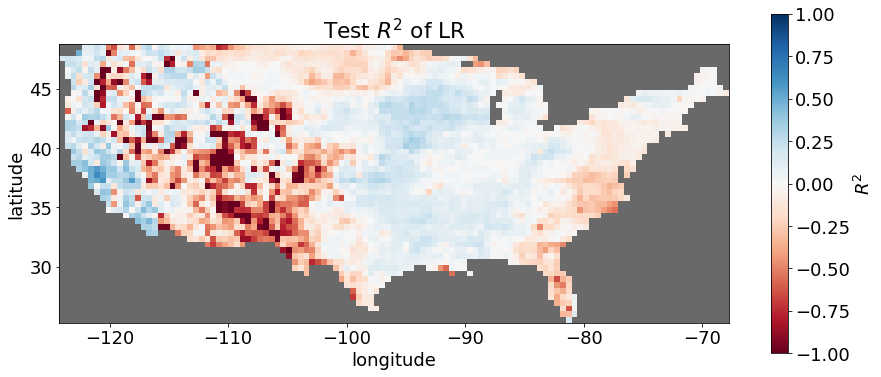

In [107]:
r2_test_rf[mask_US_cropped == 0] = np.float64('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(r2_test, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of UNET')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')

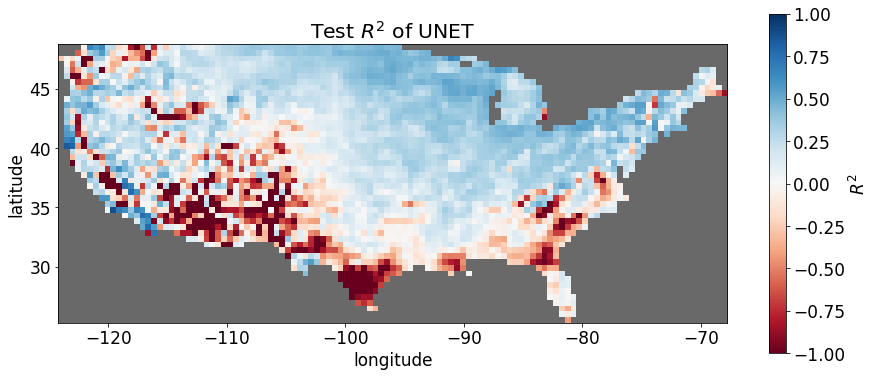

In [77]:
r2_test_rf[mask_US_cropped == 0] = np.float64('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(r2_test, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of UNET')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')